# Linear Regression

<div class="alert alert-block alert-info">
<font size=4>
This notebook is a simple demonstration of machine leraning based prediction of energy consumption using linear regression.
Similar to the loading and visualization notebook, the database along with weather was loaded. The features which are required for machine learning are generated using pandas. Then all the features/columns are plotted for viewing the correlation of the features. The dataset is then split into train and test using the sklearn's train_test_split. A linear regression model is then initiated using sklearn. The training data is fit to the model and the predicted on the test data. The test data and predicted values are combined to visualize the model.
</font>
</div>


In [1]:
import pandas as pd
from os.path import join
%matplotlib inline
from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = (10, 6)

In [96]:
root_path = 'C:/Users/MANOJ/ML_SmartMeterAnalytics'
disaggregated_path = root_path+'/data/consumption/'
data_path = root_path+'/data/'
weather_path = root_path+'/data/weather/'

In [3]:
combined_raw = pd.HDFStore(join(disaggregated_path,'all_houses_raw_AC.h5'))
key = combined_raw.keys()[0].replace('/','')
dataframe_raw = combined_raw.get(key)
combined_raw.close()

In [5]:
df_raw = dataframe_raw.copy()

In [140]:
%run functions.ipynb

In [7]:
building = '5545' #selecting one building from the list
consum_col = 'air conditioner1_'+building
consum_col_raw = 'air conditioner_'+building
consum_col_mains = 'air conditioner_'+building+'_mains'

In [8]:
weather = pd.DataFrame(load_weather_data(weather_path,'/Austin_weather_2014.csv','temperature',0),columns=['temperature'])

irradiance = pd.DataFrame(load_irradiance_data(weather_path,'/irradiance_2014_gen.csv','gen',1))
# The irradiance data was obtained from the PV generation units from the buildings.
# The system may sometimes record negative values, which makes no sense from an irradiance point of view.
# so the negative values have been set to zero.
irradiance[irradiance['gen'] <0.0] = 0

In [9]:
df_mod = (df_raw[[consum_col_raw]]).shift(-5)
df_mod_amb = df_mod.join([weather,irradiance]).dropna()

In [25]:
df_features = features_creation(df_mod_amb)

In [26]:
df_lagged = lag_column(df_features,[consum_col_raw],lag_period=24)
df_lagged = lag_column(df_lagged,['temperature'],lag_period=5)
df_lagged['gen_5'] = df_lagged['gen'].shift(5)
df_lagged['gen_6'] = df_lagged['gen'].shift(6)
df_lagged.dropna(inplace=True)

Visualizing the pearson correlation of all the columns with seaborn

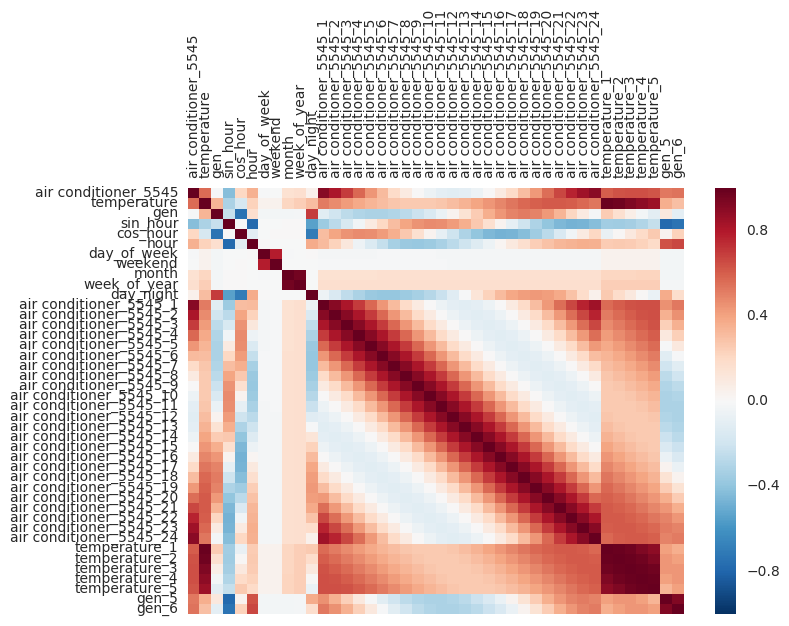

In [76]:
plot_correlation(df_lagged)

In [34]:
target_name = consum_col_raw
features = df_lagged[[col for col in df_lagged.columns if col not in target_name]]
target = df_lagged[[target_name]]

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=41234)

In [38]:
from sklearn import linear_model
linear_reg = linear_model.LinearRegression()

In [39]:
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
predict = linear_reg.predict(X_test)

In [63]:
predictions = pd.Series(predict.ravel(),index=y_test.index).rename(consum_col_raw+'_predicted')

In [64]:
predictions_frame = pd.DataFrame(predictions).join(y_test)

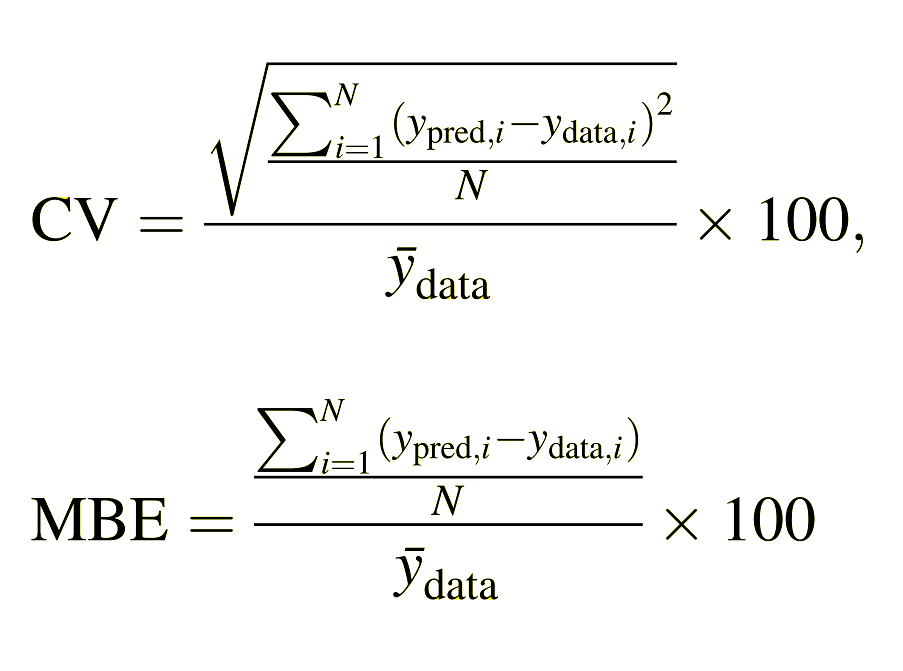

In [97]:
from IPython.display import Image
Image(filename=root_path+'/notebook/images_on_notebooks/accuracy_metric_from_S_Karatasou_et_al.png', width=400, height=400)

In [143]:
# Accuracy metrics
metrics = accuracy_metrics()
print "coefficient of variance = {:.2f}".format(metrics.coeff_var(predictions_frame,consum_col_raw,consum_col_raw+'_predicted')*100)
print "Mean bias error = {:.2f}".format(metrics.mean_bias_err(predictions_frame,consum_col_raw,consum_col_raw+'_predicted')*100)
print "R Squared = {:.3f}".format(metrics.r2_score(predictions_frame,consum_col_raw,consum_col_raw+'_predicted'))

coefficient of variance = 59.31
Mean bias error = 33.67
R Squared = 0.901


(0, 4000)

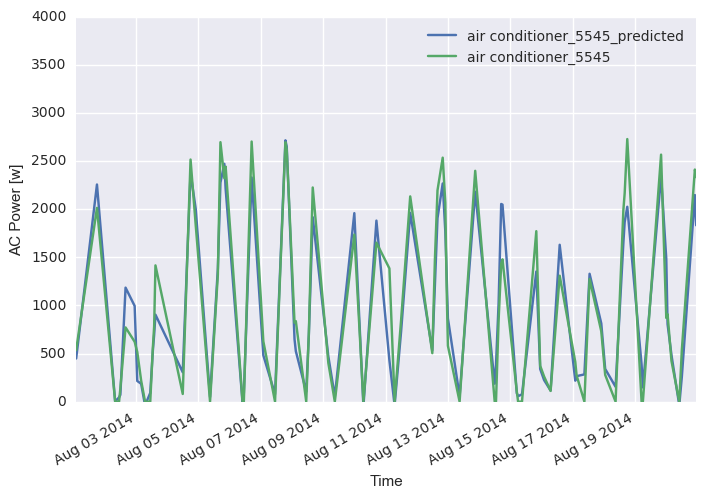

In [148]:
predictions_frame['2014-08-01':'2014-08-20'].plot()
plt.xlabel('Time')
plt.ylabel('AC Power [w]')
plt.ylim([0,4000])